# Prediksi kasus pasien terkonfirmasi COVID19 

### Penjelasan mengenai dataset
dataset berasal dari Johns Hopkins University
* github = https://github.com/CSSEGISandData/COVID-19
* kaggle = https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

###  Penjelasan mengenai fitur-fitur dataset
   * Sno = Serial number 
   * ObservationDate = Tanggal Observasi dengan format  MM / DD / YYYY
   * Province/State = Provinsi atau negara bagian dari Observasi
   * Country/Region = Negara tempat dilakukannya Observasi 
   * Last Update = Waktu dalam UTC di mana baris diperbarui untuk provinsi atau negara tertentu
   * Confirmed = Jumlah kumulatif kasus pasien yang dikonfirmasi hingga tanggal tersebut
   * Deaths = Jumlah kumulatif kematian pasien Covid19 hingga tanggal tersebut
   * Recovered = Jumlah kumulatif kasus pasien yang sembuh hingga tanggal itu

## 1. Import beberapa library yang akan kita gunakan 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

## 2. Proses Load dataset covid 19

In [2]:
covid=pd.read_csv("covid_19_data.csv")
covid.head(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0


## Informasi mengenai dimensi dari dataset. 

Diketahui bahwa dataset ini memiliki 13529 baris dan 8 buah kolom

In [3]:
covid.shape

(13529, 8)

perintah diatas memiliki fungsi untuk mengecek apakah dataset yang kita masukan tadi mempunyai data kosong.

In [4]:
covid.isnull().sum()

SNo                   0
ObservationDate       0
Province/State     6562
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

ada baiknya kita juga mengecek tipe data dari variabel-variabel dataset kita

In [5]:
covid.dtypes

SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

## 3. Preprocessing + Visualisasi dataset

dikarenakan setelah kita mengecek dataset pada tahap sebelumnya, informasi pada varibel SNO dan variabel Province/State tidak begitu penting dan banyak data NAN. sehingga dapat kita DROP pada tahap ini

In [6]:
covid.drop(["SNo","Province/State"],1,inplace=True)

In [7]:
covid.head(2)

,ObservationDate,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Mainland China,1/22/2020 17:00,14.0,0.0,0.0


Tahap selanjutnya kita mengkonversikan data ObservationDate kedalm format DateTime

In [8]:
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [9]:
covid.head(2)

,ObservationDate,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Mainland China,1/22/2020 17:00,14.0,0.0,0.0


### Selanjutnya kita kelompokkan beberapa kasus berdasarkan ObservationDate

In [10]:
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

### 3.1 Analisa kasus berdasarkan Tanggal atau perhari 

Jumlah Total Kasus pasien Covid19

In [11]:
print("jumlah total negara yang terjangkit virus Covid19 ",len(covid["Country/Region"].unique()))
print("Jumlah total Kasus Terkonfirmasi Covid19 di Seluruh Dunia: ",datewise["Confirmed"].iloc[-1])
print("jumlah total Kasus pasien yang sembuh di Seluruh Dunia: ",datewise["Recovered"].iloc[-1])
print("jumlah total Kasus Kematian pasien di Seluruh Dunia: ",datewise["Deaths"].iloc[-1])
print("Jumlah total Kasus pasien aktif di Seluruh Dunia: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Jumlah total kasus pasien non-aktif : ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])

jumlah total negara yang terjangkit virus Covid19  219
Jumlah total Kasus Terkonfirmasi Covid19 di Seluruh Dunia:  1595350.0
jumlah total Kasus pasien yang sembuh di Seluruh Dunia:  353975.0
jumlah total Kasus Kematian pasien di Seluruh Dunia:  95455.0
Jumlah total Kasus pasien aktif di Seluruh Dunia:  1145920.0
Jumlah total kasus pasien non-aktif :  449430.0


Perkiraan Jumlah kasus pasien perharinya 

In [12]:
print("Perkiraan jumlah Kasus pasien terkonfirmasi Covid19 per Hari di Seluruh Dunia: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Perkiraan jumlah Kasus pasien yang sembuh per Hari di Seluruh Dunia: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Perkiraan jumlah Kasus Kematian pasien per Hari di Seluruh Dunia: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))

Perkiraan jumlah Kasus pasien terkonfirmasi Covid19 per Hari di Seluruh Dunia:  20194.0
Perkiraan jumlah Kasus pasien yang sembuh per Hari di Seluruh Dunia:  4481.0
Perkiraan jumlah Kasus Kematian pasien per Hari di Seluruh Dunia:  1208.0


In [13]:
print("Perkiraan jumlah Kasus pasien Terkonfirmasi per jam di seluruh Dunia: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Perkiraan jumlah Kasus pasien yang sembuh per jam di seluruh Dunia: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Perkiraan jumlah Kasus Kematian pasien per jam di seluruh Dunia: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))

Perkiraan jumlah Kasus pasien Terkonfirmasi per jam di seluruh Dunia:  841.0
Perkiraan jumlah Kasus pasien yang sembuh per jam di seluruh Dunia:  187.0
Perkiraan jumlah Kasus Kematian pasien per jam di seluruh Dunia:  50.0


Visualisasi data perkembangan pasien aktif yang terjangkit Covid19

Kasus pasien aktif = Jumlah Kasus pasien yang terkonfirmasi Covid19 - Jumlah Kasus pasien yang sembuh - Jumlah Kasus Kematian Pasien

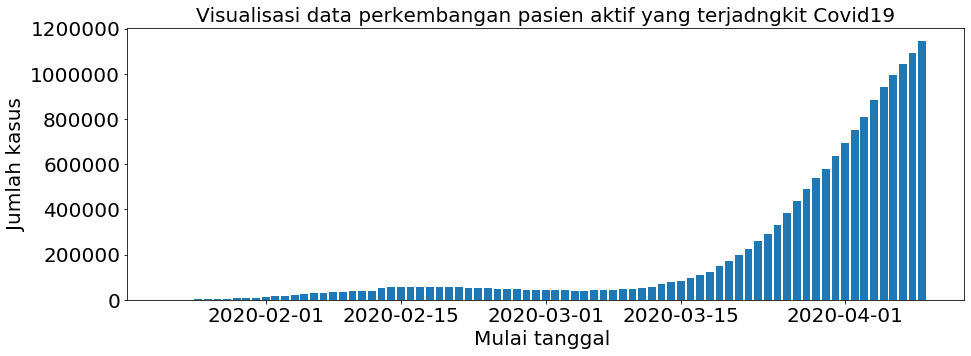

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(datewise.index.date, datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
plt.title("Visualisasi data perkembangan pasien aktif yang terjadngkit Covid19", size=20)
plt.xlabel('Mulai tanggal ', size=20)
plt.ylabel('Jumlah kasus', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Visualisasi data perkembangan pasien non-aktif yang terjangkit Covid19

Kasus pasien non-aktif = Jumlah Kasus pasien yang sembuh + Jumlah Kasus Kematian pasien

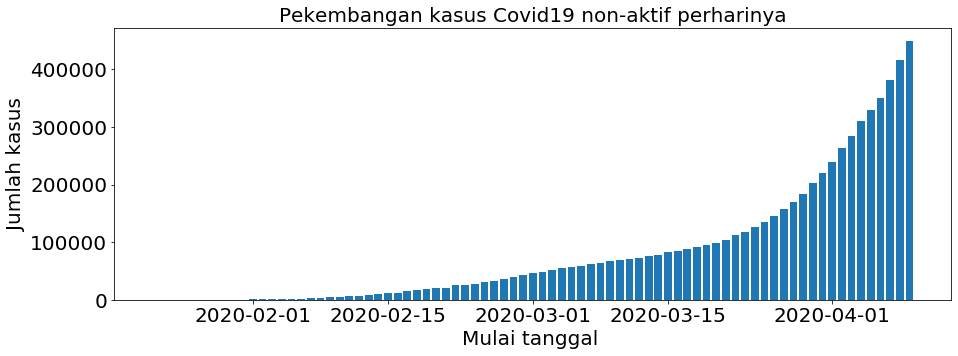

In [15]:
plt.figure(figsize=(15, 5))
plt.bar(datewise.index.date, datewise["Recovered"]+datewise["Deaths"])
plt.title('Pekembangan kasus Covid19 non-aktif perharinya', size=20)
plt.xlabel('Mulai tanggal ', size=20)
plt.ylabel('Jumlah kasus', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 3.2 Analisa berdasarkan perminggu 

Berikut kita terlebih dahulu buat fungsi berdasarkan perminggunya

In [16]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

Visualisasi data berbagai jenis kasus perminggunya

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, **kwargs)>

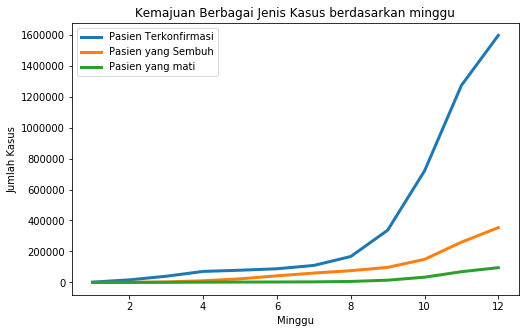

In [17]:
plt.figure(figsize=(8,5))
plt.plot(week_num,weekwise_confirmed,linewidth=3)
plt.plot(week_num,weekwise_recovered,linewidth=3)
plt.plot(week_num,weekwise_deaths,linewidth=3)
plt.legend(["Pasien Terkonfirmasi", "Pasien yang Sembuh","Pasien yang mati"])
plt.ylabel("Jumlah Kasus")
plt.xlabel("Minggu")
plt.title("Kemajuan Berbagai Jenis Kasus berdasarkan minggu")
plt.xlabel

### 3.3 Analisa kasus berdasarkan Negara

Visualisasi data berdaraskan 5 negara yang memiliki kasus terkonfirmasi Covid19 tertinggi

In [18]:
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)

Text(0.5, 1.0, '5 negara yang memiliki kasus terkonfirmasi Covid19 tertinggi')

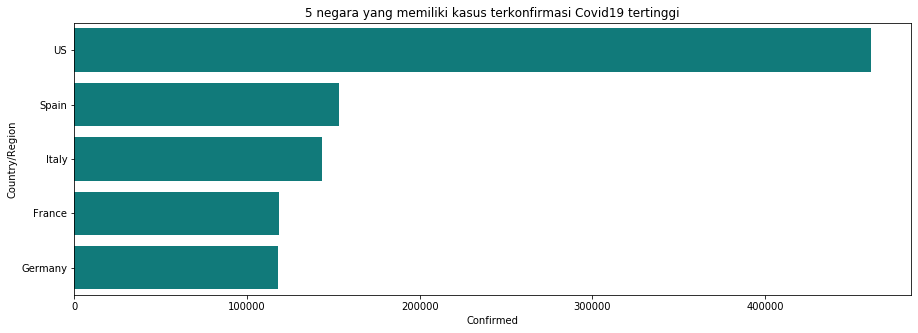

In [19]:
fig, (ax1) = plt.subplots(figsize=(15,5))
Negara_terkonfirmasi_tertinggi=countrywise.sort_values(["Confirmed"],ascending=False).head(5)
sns.barplot(x=Negara_terkonfirmasi_tertinggi["Confirmed"],y=Negara_terkonfirmasi_tertinggi.index,ax=ax1,color="darkcyan")
ax1.set_title("5 negara yang memiliki kasus terkonfirmasi Covid19 tertinggi")

Visualisasi data berdaraskan 5 negara yang memiliki kasus kematian pasien tertinggi

Text(0.5, 1.0, '5 negara yang memiliki kasus kematian pasien tertinggi')

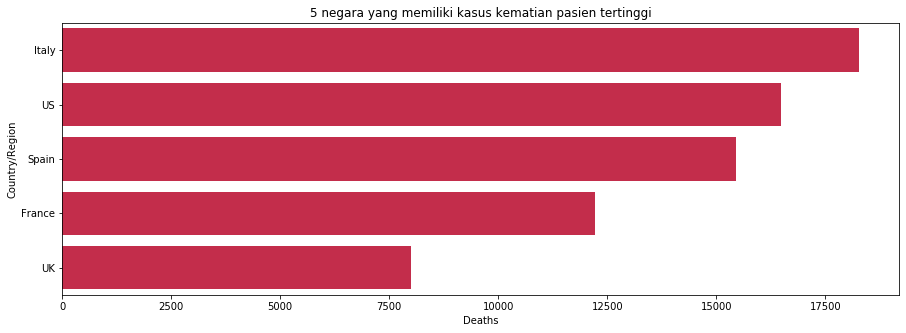

In [20]:
fig, (ax1) = plt.subplots(figsize=(15,5))
Negara_terkonfirmasi_Kematian_tertinggi=countrywise.sort_values(["Deaths"],ascending=False).head(5)
sns.barplot(x=Negara_terkonfirmasi_Kematian_tertinggi["Deaths"],y=Negara_terkonfirmasi_Kematian_tertinggi.index,ax=ax1,color="crimson")
ax1.set_title("5 negara yang memiliki kasus kematian pasien tertinggi")

Visualisasi data berdaraskan 5 negara yang memiliki kasus kesembuhan pasien tertinggi

Text(0.5, 1.0, '5 negara yang memiliki kasus kesembuhan pasien tertinggi')

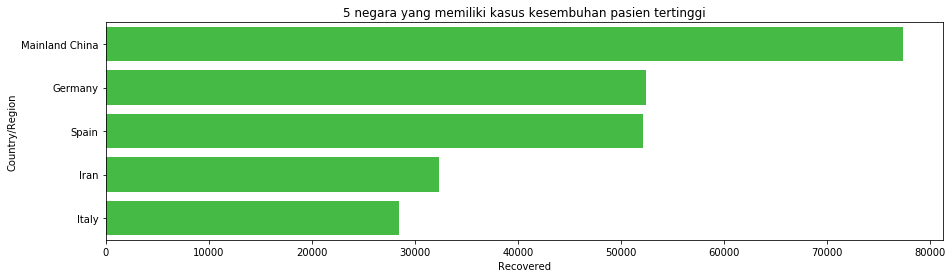

In [21]:
fig, (ax1) = plt.subplots(figsize=(15,4))
Negara_terkonfirmasi_Kesembuhan_tertinggi=countrywise.sort_values(["Recovered"],ascending=False).head(5)
sns.barplot(x=Negara_terkonfirmasi_Kesembuhan_tertinggi["Recovered"],y=Negara_terkonfirmasi_Kesembuhan_tertinggi.index,ax=ax1,color="limegreen")
ax1.set_title("5 negara yang memiliki kasus kesembuhan pasien tertinggi")

# 4. Analisis data pada negara Amerika (US)

pada codingan dibawah berfungsi untuk melihat bebrapa informasi mengenai jumlah  pasien yang terkonfirmasi Covid19, jumlah Pasien yang sembuh, jumlah pasien yang meninggal pada negara amreika serikat 

In [22]:
US_data=covid[covid["Country/Region"]=="US"]
datewise_US=US_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_US.iloc[-1])
print("Total Active Cases: ",datewise_US["Confirmed"].iloc[-1]-datewise_US["Recovered"].iloc[-1]-datewise_US["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_US["Recovered"].iloc[-1]+datewise_US["Deaths"].iloc[-1])

Confirmed    461437.0
Recovered     25410.0
Deaths        16478.0
Name: 2020-04-09 00:00:00, dtype: float64
Total Active Cases:  419549.0
Total Closed Cases:  41888.0


Untuk mempermudah kita melihat informasi diatas, ada baiknya kita menampilkan informasi diatas dengan bantuan visual yang dapat dilihat pada informasi dibawah ini 

### 4.1 Visualisasi Tingkat Pertumbuhan untuk Berbagai Jenis Kasus Covid19 di Amerika

Text(0.5, 1.0, 'Tingkat Pertumbuhan untuk Berbagai Jenis Kasus Covid19 di Amerika')

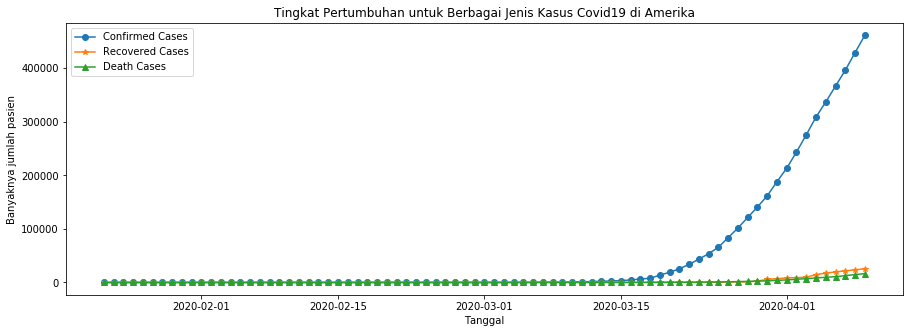

In [23]:
fig, (ax1) = plt.subplots(figsize=(15,5))
ax1.plot(datewise_US["Confirmed"],marker='o',label="Confirmed Cases")
ax1.plot(datewise_US["Recovered"],marker='*',label="Recovered Cases")
ax1.plot(datewise_US["Deaths"],marker='^',label="Death Cases")
ax1.set_ylabel("Banyaknya jumlah pasien")
ax1.set_xlabel("Tanggal")
ax1.legend()
ax1.set_title("Tingkat Pertumbuhan untuk Berbagai Jenis Kasus Covid19 di Amerika")

### 4.2 Visualisasi Jumlah Kasus Aktif di negara Amerika 

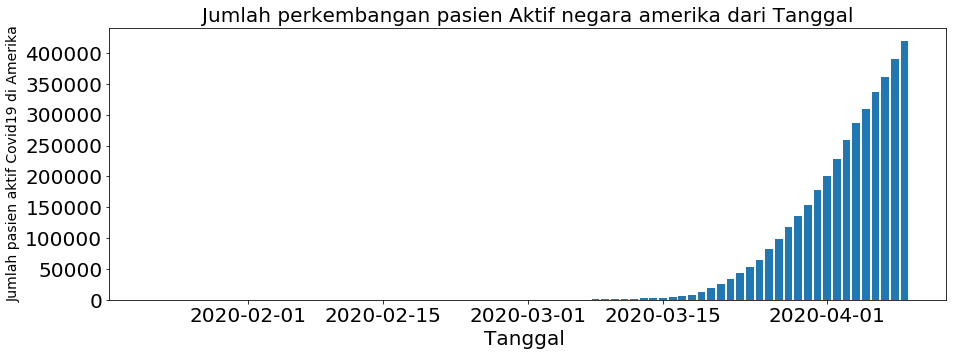

In [24]:
plt.figure(figsize=(15, 5))
plt.bar(datewise_US.index.date,datewise_US["Confirmed"]-datewise_US["Recovered"]-datewise_US["Deaths"])
plt.title('Jumlah perkembangan pasien Aktif negara amerika dari Tanggal', size=20)
plt.xlabel('Tanggal ', size=20)
plt.ylabel('Jumlah pasien aktif Covid19 di Amerika', size=14)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 4.3 Visualisasi Jumlah Kasus Aktif di negara Amerika


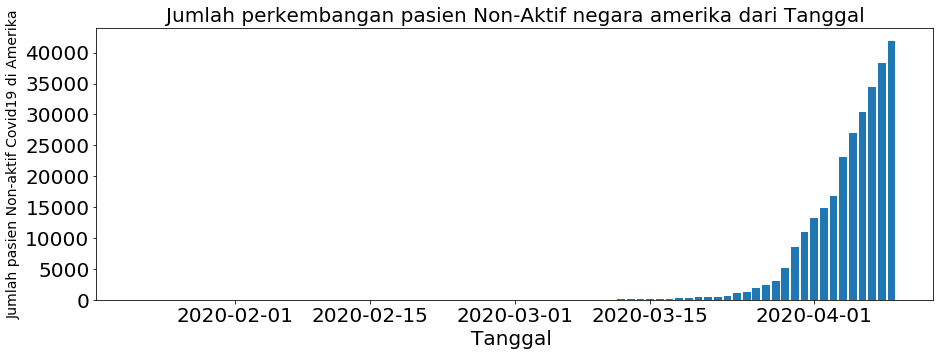

In [25]:
plt.figure(figsize=(15, 5))
plt.bar(datewise_US.index.date,datewise_US["Recovered"]+datewise_US["Deaths"])
plt.title('Jumlah perkembangan pasien Non-Aktif negara amerika dari Tanggal', size=20)
plt.xlabel('Tanggal ', size=20)
plt.ylabel('Jumlah pasien Non-aktif Covid19 di Amerika', size=14)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# 5. Prediksi Kasus Covid19

### 5.1 Metode Liniear Regression 

In [26]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [27]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.90)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.90):]
model_scores=[]

In [28]:
valid_ml.head(2)

,Confirmed,Recovered,Deaths,WeekOfYear,Days Since
ObservationDate,,,,,
2020-04-02,1013303.0,210263.0,52983.0,14,71
2020-04-03,1095917.0,225796.0,58787.0,14,72


In [29]:
lin_reg=LinearRegression(normalize=True)

In [30]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [31]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [32]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  838197.9203347286


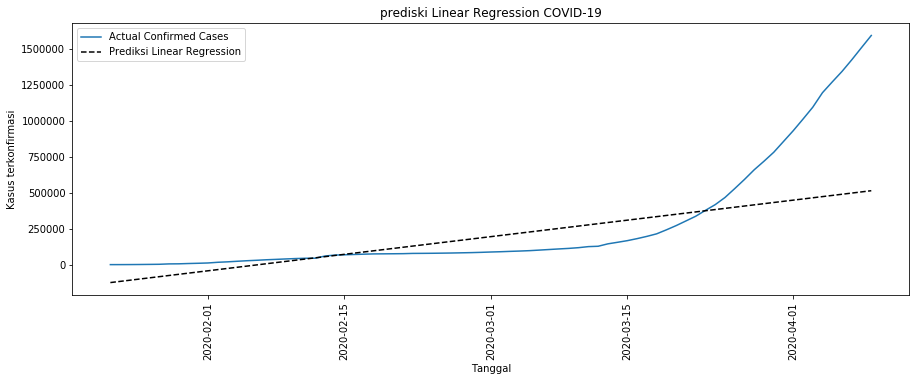

In [33]:
plt.figure(figsize=(15,5))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_linreg, linestyle='--',label="Prediksi Linear Regression",color='black')
plt.xlabel('Tanggal')
plt.ylabel('Kasus terkonfirmasi')
plt.title("prediski Linear Regression COVID-19")
plt.xticks(rotation=90)
plt.legend()

### 5.2 Metode Holt's

In [34]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.90)]
valid=datewise.iloc[int(datewise.shape[0]*0.90):]

In [35]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.9, smoothing_slope=0.9)
y_pred=valid.copy()

In [36]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  37711.476426752706


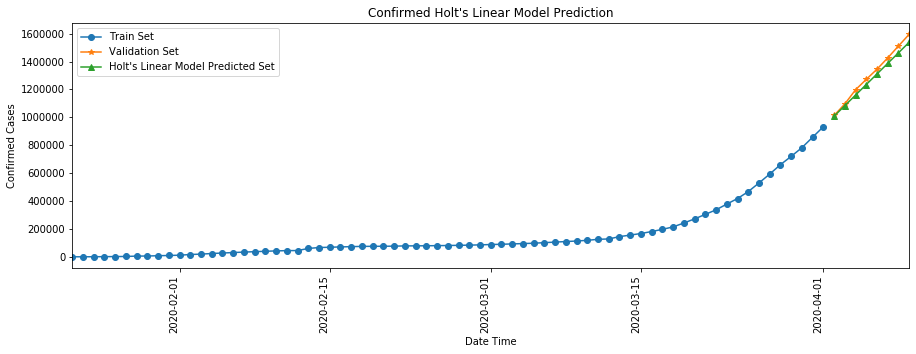

In [37]:
plt.figure(figsize=(15,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred.Holt.plot(label="Holt's Linear Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Confirmed Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

### 5.3 Perbandingan antara nilai prediksi menggunan 2 metode diatas

In [38]:
new_date=[]
new_prediction_lr=[]
holt_new_prediction=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])


In [39]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,holt_new_prediction),columns=["Dates","Linear Regression Prediction","Holt's Model Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Holt's Model Prediction
0,2020-04-10,523112.121529,1613811.431827
1,2020-04-11,531307.744970,1689544.992684
2,2020-04-12,539503.368410,1765278.553541
3,2020-04-13,547698.991851,1841012.114398
4,2020-04-14,555894.615292,1916745.675256
